In [ ]:
# Install all required packages
!python3 -m pip -q install sklearn seaborn tueplots mpmath quadpy

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.model_selection import train_test_split

from tueplots import axes, bundles, cycler, figsizes, fonts

from PrivDPS import (DirichletMechanism,
                     GaussianMechanism,
                     Gohari,
                     LaplaceMechanism,
                     MLECalculator)
from utils import MajorSymLogLocator, symlogfmt

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"figure.dpi": 600})
plt.rcParams.update(fonts.jmlr2001_tex(family="serif"))
plt.rcParams.update(bundles.icml2022(family="serif"))
plt.rcParams.update(figsizes.icml2022_full(nrows=1))
plt.rcParams.update(cycler.cycler(color=sns.color_palette("bright", 4)))
plt.rcParams.update(axes.lines())
plt.rcParams.update(axes.grid(grid_alpha=0.7))
plt.rcParams.update({'legend.fontsize': 6.5,
                     'legend.handlelength': 2
                    }
                   )
seed = 1
n_repeat = 10
n_bins = 10
delta = 1e-5
rs = np.logspace(-4.1, -0.1, 10)
eps_list = np.logspace(-3, 1, 10)
eps_mult = {filename: 0
            for filename in os.listdir('data')}
eps_gohari = {filename: np.empty(rs.shape[0])
              for filename in os.listdir('data')}
model_list = ['Non-private', 'Dirichlet', 'Gohari et al.', 'Gaussian', 'Laplace']
file_list = ["Adult.csv", "Bank.csv", "GermanCredit.csv"]
results = {filename: {model: np.empty((eps_list.shape[0], n_repeat))
                      for model in model_list}
           for filename in file_list}

bayesian_nets = {"Adult.csv": {"age": [],
                               "sex": [],
                               "education": ["age"],
                               "occupation": ["age", "sex", "education"],
                               "capital-gain": ["sex", "education", "occupation"],
                               "capital-loss": ["sex", "occupation", "capital-gain"],
                               "income": ["occupation", "capital-gain", "capital-loss"]},
                 "Bank.csv": {"month": [],
                              "day_of_week": [],
                              "housing": ["month"],
                              "pdays": ["housing", "month"],
                              "poutcome": ["housing", "pdays"],
                              "previous": ["poutcome"],
                              "contact": ["previous", "month"],
                              "campaign": ["day_of_week", "month"],
                              "duration": ["housing", "contact", "campaign"],
                              "y": ["poutcome", "duration", "month"]},
                 "GermanCredit.csv": {"housing": [],
                                      "property": ["housing"],
                                      "age": ["housing"],
                                      "amount": ["property"],
                                      "other_debtors": ["property"],
                                      "sex_marital_status": ["amount"],
                                      "purpose": ["amount"],
                                      "installment_rate": ["amount"],
                                      "duration": ["amount", "installment_rate"],
                                      "people_liable": ["sex_marital_status"],
                                      "foreign_worker": ["duration"],
                                      "number_credits": ["age"],
                                      "credit_history": ["number_credits"],
                                      "other_installment_plans": ["credit_history"]}}


def prepare_data(filename, num_bins, seed):
    X = pd.read_csv(filename)

    X_train, X_test = train_test_split(
        X, test_size=0.3, random_state=seed)

    # remove cols with only one category
    cat_counts = X_train.nunique()
    X_train = X_train.loc[:, cat_counts!=1]
    X_test = X_test.loc[:, cat_counts!=1]

    # quantile binning while preserving repeated values
    N = X_train.shape[0]
    for col in X_train.columns:
        train_series = X_train[col].copy()
        if train_series.dtype != 'O':
            counts = train_series.value_counts()
            if counts.shape[0] > 30:
                idx = 0
                while idx < counts.shape[0] and counts.iloc[idx] > N/(3**(idx+1)):
                    idx += 1
                if idx < counts.shape[0] and counts.shape[0] - idx > 30:
                    train_remain_idx = train_series.isin(counts.index[idx:])
                    train_subset = train_series[train_remain_idx]
                    train_subset, bins = pd.qcut(train_subset,
                                                 num_bins,
                                                 retbins=True,
                                                 duplicates='drop')
                    X_train.loc[train_remain_idx, col] = train_subset

                    test_series = X_test[col].copy()
                    test_remain_idx = test_series.isin(counts.index[idx:])
                    test_subset = test_series[test_remain_idx]
                    X_test.loc[test_remain_idx, col] = pd.cut(test_subset, bins)

    X_train = X_train.astype(str)
    X_test = X_test.astype(str)
    return X_train, X_test


def sample_parameters(data, bayesian_net, sampler):
    param_dict = {}
    count_dict = {}
    for col in bayesian_net.keys():
        if not bayesian_net[col]:
            counts = data[col].value_counts()
            count_dict[col] = counts
            param_dict[col] = sampler.sample_series(counts)
        else:
            data_subset = data[bayesian_net[col] + [col]]
            counts = data_subset.groupby(bayesian_net[col]).value_counts()
            count_dict[col] = counts
            grouped_counts = counts.groupby(bayesian_net[col],
                                            group_keys=False)
            param_dict[col] = grouped_counts.apply(sampler.sample_series)

    return param_dict, count_dict


def loglikelihood(counts, params):
    ll = 0
    for node in counts.keys():
        ll += (np.log(params[node])*counts[node]).sum()

    return ll


In [ ]:
for filename in file_list:
    print(filename)
    X_train, X_test = prepare_data(os.path.join('data',filename),
                                   n_bins,
                                   seed)
    eps_mult[filename] = 2*np.sqrt(2*X_train.shape[1]*np.log(1/delta)) 
    _, count_dict = sample_parameters(X_test, 
                                      bayesian_nets[filename],
                                      MLECalculator(prior=0.1))
    num_child_nodes = len(bayesian_nets.keys())
    delta_adjusted = 0.5*delta/num_child_nodes
    for i, epsilon in enumerate(eps_list):
        ml = MLECalculator(prior=0.1)
        dm = DirichletMechanism(epsilon=epsilon, lambda_=5, prior=1)
        dm.set_dp_epsilon(epsilon, delta_adjusted)
        gm = GaussianMechanism(epsilon=epsilon, lambda_=5)
        gm.set_dp_epsilon(epsilon, delta_adjusted)
        lm = LaplaceMechanism(epsilon=epsilon, lambda_=5, d=num_child_nodes)
        lm.set_dp_epsilon(epsilon, delta_adjusted)
        gh = Gohari(epsilon=epsilon, lambda_=5, prior=1, N=X_train.shape[0])
        gh.set_r(rs[i], X_train, delta_adjusted)
        if gh.has_none is True:
            results[filename]['Gohari et al.'][i] = [None]*n_repeat
            results[filename]['Gohari et al.'][i] = [None]*n_repeat
            zipped = zip([model_list[s] for s in [0, 1, 3, 4]],
                         [ml, dm, gm, lm])
        else:
            eps_gohari[filename][i] = gh.epsilon
            zipped = zip(model_list, [ml, dm, gh, gm, lm])
        for name, sampler in zipped:
            for j in range(n_repeat):
                param_dict, _ = sample_parameters(X_train,
                                                  bayesian_nets[filename],
                                                  sampler)
                ll = loglikelihood(count_dict, param_dict)
                results[filename][name][i, j] = ll

In [4]:
import pickle

with open('likelihood_dp_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('nb_eps_gohari.pickle', 'wb') as handle:
    pickle.dump(eps_gohari, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('likelihood_dp_results.pickle', 'rb') as handle:
#    results = pickle.load(handle)

#with open('eps_gohari.pickle', 'rb') as handle:
#    eps_gohari = pickle.load(handle)

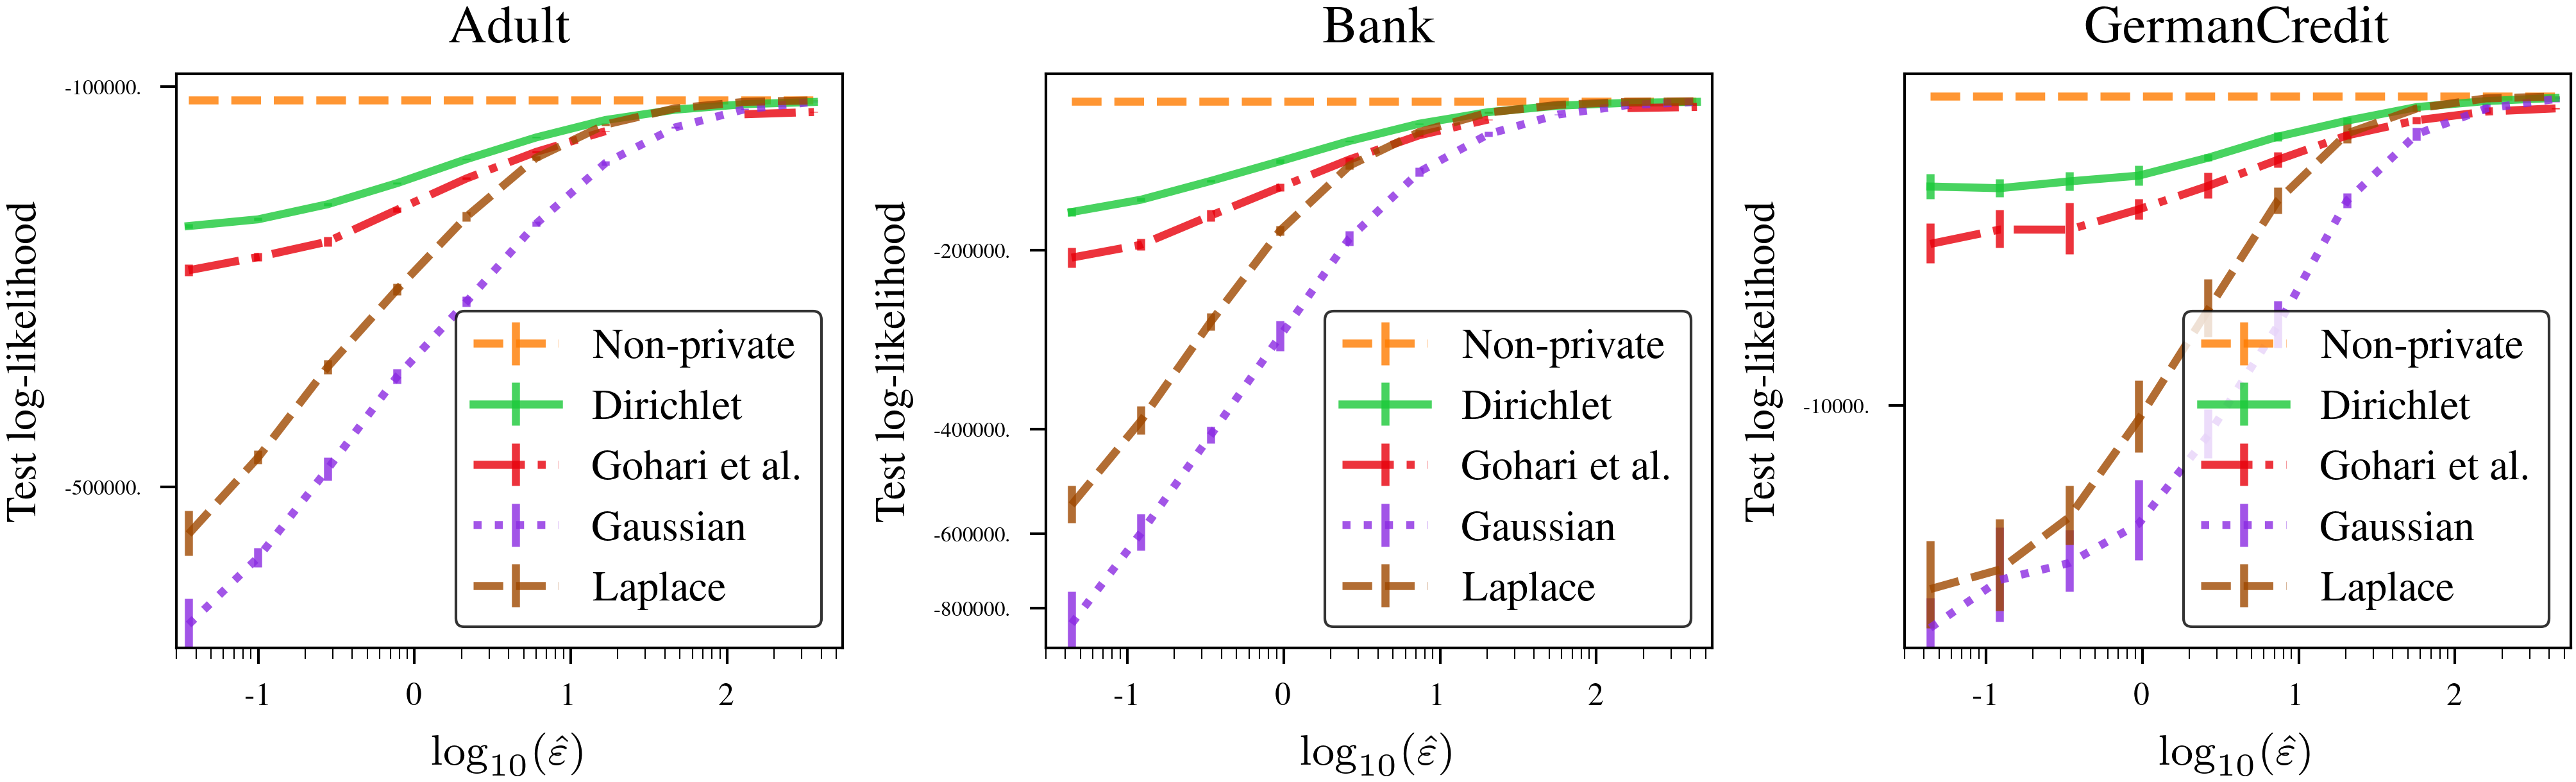

In [11]:
%matplotlib inline

plt.rcParams.update(cycler.cycler(color=sns.color_palette("bright", 6)))

fig, axs = plt.subplots(nrows=1, ncols=3)
bars = [None]*len(model_list)
linestyles = ['--', '-', '-.', ':', '--']
eps_list_seq = [eps_list]*5

for data, ax in zip(file_list, axs.flatten()):
    eps_list_seq[2] = eps_gohari[data]
    ax._get_lines.get_next_color()
    for i, model in enumerate(model_list):
        bars[i] = ax.errorbar(eps_list*eps_mult[data],
                              results[data][model].mean(axis=1),
                              yerr=results[data][model].std(axis=1),
                              label=model,
                              lw=1.5,
                              ls=linestyles[i],
                              alpha=0.8)
    ax.set_xlabel('$\\log_{10}(\\hat\\varepsilon)$')
    ax.set_xscale('log')
    ax.set_yscale('symlog')
    ax.set_xlim(0.03, 550)
    ax.set_xticks([0.1, 1, 10, 100])
    ax.set_xticklabels([-1, 0, 1, 2])
    ax.set_ylim(results[data]['Gaussian'].mean(axis=1)[0]*1.1,
                results[data]['Non-private'].mean(axis=1)[0]*0.9)
    ax.set_ylabel('Test log-likelihood')
    ax.legend(bars,
              model_list,
              loc='lower right',
              fontsize=8)
    ax.tick_params(axis='y', which='major', labelsize=4)
    ax.yaxis.set_major_locator(MajorSymLogLocator())
    ax.yaxis.set_major_formatter(FuncFormatter(symlogfmt))
    #ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax.set_title(data[:-4], fontsize=10)

fig.tight_layout()
fig.savefig('dp_log-likelihood.pdf', bbox_inches='tight', format='pdf', dpi=1200)